## Import libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

## Dataset class inheritance from torch `Dataset` class    

In [16]:
"Header: 1:Abs,2:Espesor,3:Ref,4:Cal"
class buildingDataset(Dataset):
    def __init__(self, csv_file):
        # Ignore header
        self.data = pd.read_csv(csv_file, header=0)
        self.root = csv_file
        self.len = self.data.shape[0]
    def __getitem__(self, index):
        return torch.tensor(self.data.iloc[index, :].values, dtype=torch.float)
    def __len__(self):
        return self.len

## Model Class

In [26]:
# Creating the model
class MLP(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_layers=[32, 32]):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers

        layers = []
        prev_layer_size = input_dim
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(nn.ReLU())
            prev_layer_size = layer_size
        layers.append(nn.Linear(prev_layer_size, output_dim))
        self.layers = nn.Sequential(*layers)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=5e-3)
        self.criterion = nn.MSELoss()

        self.loss = []
        self.loss_val = []


        self.index_features = [0,1] # features input is in data frame 
        self.index_labels = [2,3] # label output in data frame 

        # if torch.cuda.is_available():
        #     self.device = torch.device('cuda')
        # else:
        #     self.device = torch.device('cpu')
        self.device = torch.device('cpu')

    def forward(self, x):
        return self.layers(x)

    """ Trains the model """
    def train(self, train_loader, val_loader, optimizer=None, criterion=None, num_epochs=2000, verbose=False):
        if optimizer is None:
            optimizer = self.optimizer
        if criterion is None:
            criterion = self.criterion
        
        for epoch in tqdm(range(num_epochs)):
            train_loss = 0.0
            for _, data in enumerate(train_loader):
                data = data.to(self.device)
                optimizer.zero_grad()
                predicted = self(data[:, self.index_features])
                ground_truths = data[:, self.index_labels] 
                loss = criterion(predicted, ground_truths)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss = self.evaluate(val_loader, criterion)
            tqdm.write(f"Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}") if verbose else None

            self.loss.append(train_loss)
            self.loss_val.append(val_loss)

    """Computes the loss on a generic dataset """    
    def evaluate(self, loader, criterion):
        val_loss = 0.0
        with torch.no_grad():
            for data in loader:
                data = data.to(self.device)
                predicted = self(data[:, self.index_features])
                ground_truths = data[:, self.index_labels] # ux,uy,uz
                loss = criterion(predicted, ground_truths)
                val_loss += loss.item()
        val_loss /= len(loader)
        return val_loss
    
    """ Compte the loss on the null model  """
    def evaluate_null(self, loader, criterion):
        baseline_loss = 0.0
        with torch.no_grad():
            for data in loader:
                data = data.to(self.device)
                predicted = torch.zeros_like(data[:, self.index_labels])
                ground_truths = data[:, self.index_labels]
                loss = criterion(predicted, ground_truths)
                baseline_loss += loss.item()
            
        baseline_loss /= len(loader)
        return baseline_loss

## Evaluate the model

100%|██████████| 50000/50000 [02:18<00:00, 360.66it/s]


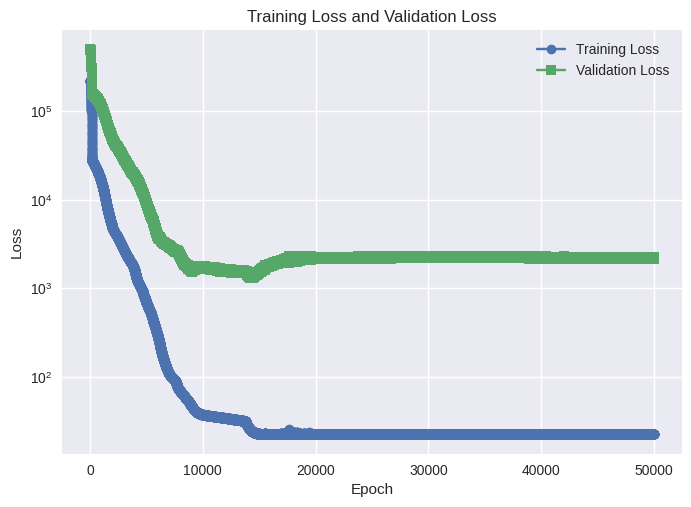

Train loss:  22.42913246154785
Validation loss:  2225.974853515625
Test loss:  3908.1259765625
Baseline loss:  354596.625
Train Relative loss:  6.325252661823234e-05
Validation Relative loss:  0.006277484602442635
Test Relative loss:  0.0110213287466075


In [33]:
# Loading the data
dataset = buildingDataset("./datosPrueba1.csv")

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Creating data loaders
batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Print a summary of a dataset 

# Defining the model
mlp = MLP()
# Training the model
mlp.train(train_loader =train_loader, val_loader=val_loader, num_epochs=50000) 

# ## Plotting the loss
plt.style.use("seaborn-v0_8")
plt.semilogy(mlp.loss, label='Training Loss', marker='o')
plt.semilogy(mlp.loss_val, label='Validation Loss', marker='s')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.show()

# #save the image
# plt.savefig('./loss.png')

# # Evaluate test loss
test_loss = mlp.evaluate(test_loader, mlp.criterion) 
# Print the final losses 
print('Train loss: ', mlp.loss[-1])
print('Validation loss: ', mlp.loss_val[-1])
print('Test loss: ', test_loss)

# # Compute baseline loss
baseline_loss = mlp.evaluate_null(test_loader, mlp.criterion)
print('Baseline loss: ', baseline_loss)

# Print relative losses
print('Train Relative loss: ', mlp.loss[-1]/baseline_loss)
print('Validation Relative loss: ', mlp.loss_val[-1]/baseline_loss)
print('Test Relative loss: ', test_loss/baseline_loss)